In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
plt.rcParams['figure.figsize'] = (16, 9)

In [2]:
%cd ~/PycharmProjects/pqr/
from pqr.factors import Factor, WeightingFactor, FilteringFactor
from pqr.multi_factors import InterceptMultiFactor, NSortMultiFactor, WeightedMultiFactor
from pqr.factor_models import FactorModel
from pqr.benchmarks import Benchmark

/home/akbabkin/PycharmProjects/pqr


## Считываем данные

In [3]:
prices = pd.read_excel('/home/akbabkin/notebooks/summer_school/data/price.xlsx', index_col=0, parse_dates=True)
index = pd.read_excel('/home/akbabkin/notebooks/summer_school/data/benchmark.xlsx', index_col=0, parse_dates=True)

pe = pd.read_excel('/home/akbabkin/notebooks/summer_school/data/mults/pe.xlsx', index_col=0, parse_dates=True)
mcap = pd.read_excel('/home/akbabkin/notebooks/summer_school/data/financials/market_cap.xlsx', index_col=0, parse_dates=True)
volume = pd.read_excel('/home/akbabkin/notebooks/summer_school/data/liquidity/volume.xlsx', index_col=0, parse_dates=True)

## Создаем на основе данных факторы с дефолтными параметрами. 
Конструктор принимает на вход параметры:
* data
* static = False
* looking_period = 1
* lag = 0
* replace_with_nan = None
* bigger_better = True
* data_periodicity = 'monthly' (пока только daily и monthly, с другими значениями выдаст ошибку просто)

In [4]:
# основной фактор на основе P/E + фактор на основе капитализации (для мультифакторных моделей)
value = Factor(pe)
size = Factor(mcap)
# фильтрующий фактор на основе среднедневного объема (те же параметры, что и для основного + пороги)
liquidity = FilteringFactor(volume, min_threshold=1_000_000)
# взвешивающий фактор на основе капитализации
size_w = WeightingFactor(mcap)

# бенчмарк уже готовый
benchmark = Benchmark(index, index='FTSE_MIB')

## Создаем фаткорную модель

In [5]:
fm = FactorModel()

## "Обучаем" факторную модель.
Она принимает на вход:
* prices
* factor
* holding_period = 1
* filtering_factor = None (NoFilter)
* weighting_factor = None (EqualWeights)
* n_quantile_portfolios = 3

In [6]:
fm.fit(
    prices=prices,
    factor=value,
    filtering_factor=liquidity,
    weighting_factor=size_w,
    benchmark=benchmark,
    holding_period=2,
    n_quantile_portfolios=4
)

/home/akbabkin/notebooks/.datascience/lib/python3.8/site-packages/numpy/lib/nanfunctions.py:1389: RuntimeWarning: All-NaN slice encountered
  result = np.apply_along_axis(_nanquantile_1d, axis, a, q,


## После обучения у факторной модели появились портфели. С ними можно работать по отдельности

In [7]:
fm.portfolios

[QuantilePortfolio(0.00, 0.25),
 QuantilePortfolio(0.25, 0.50),
 QuantilePortfolio(0.50, 0.75),
 QuantilePortfolio(0.75, 1.00)]

In [8]:
fm.portfolios[0].alpha

Alpha(coef=-0.005394524516083877, p_value=0.1474288389138436)

In [9]:
fm.portfolios[0].returns

array([ 0.        ,  0.        ,  0.01988469,  0.02890548, -0.05322422,
       -0.14782641,  0.11310641, -0.01374797, -0.06253238,  0.08684408,
       -0.00361817,  0.16461148,  0.00646041, -0.04553346,  0.08632849,
        0.0066431 , -0.0076373 , -0.00834696,  0.05166306, -0.03509863,
        0.0283432 , -0.01378698, -0.01889879, -0.01170539,  0.08319034,
       -0.02485407, -0.01167152,  0.06142956, -0.19083209,  0.00245442,
        0.0659357 , -0.14141526,  0.03930633, -0.07258024,  0.03347868,
       -0.05568077,  0.0507542 ,  0.07730796,  0.0253995 ,  0.03178412,
       -0.14046869,  0.05556072,  0.00609125,  0.0015481 ,  0.06748325,
        0.01544519,  0.03009325,  0.00177794, -0.04019581, -0.05460758,
       -0.28913293,  0.00203248,  0.04560226,  0.04582625, -0.01247277,
        0.05874265, -0.08103042, -0.10838554,  0.30887392, -0.01696288,
       -0.05035295,  0.15352943,  0.10618295, -0.00361154])

In [10]:
# позже будут 0, 1 и -1 (это нужно для wml-портфеля, т.к. там еще и шорты)
fm.portfolios[0].positions

array([[False, False, False, ..., False, False, False],
       [False, False, False, ..., False, False, False],
       [False, False, False, ..., False, False, False],
       ...,
       [False,  True, False, ..., False, False, False],
       [False,  True, False, ..., False, False, False],
       [False, False, False, ..., False, False, False]])

In [11]:
fm.portfolios[0].sharpe

0.15714003253348002

In [12]:
fm.portfolios[0].max_drawdown

-0.605610214304736

In [13]:
fm.portfolios[0].stats

{'Alpha, %': -0.5394524516083877,
 'Alpha p-value': 0.1474288389138436,
 'Beta': 1.3328195217604513,
 'Beta p-value': 9.748075005239837e-31,
 'Sharpe Ratio': 0.15714003253348002,
 'Mean Return, %': 0.38501424890021024,
 'Excessive Return, %': -0.2218332351413551,
 'Total Return, %': 1.0508200022866676,
 'Volatility, %': 8.487515625161306,
 'Benchmark Correlation': 0.9380871176111947,
 'Profitable Periods, %': 53.125,
 'Maximum Drawdown, %': -60.5610214304736}

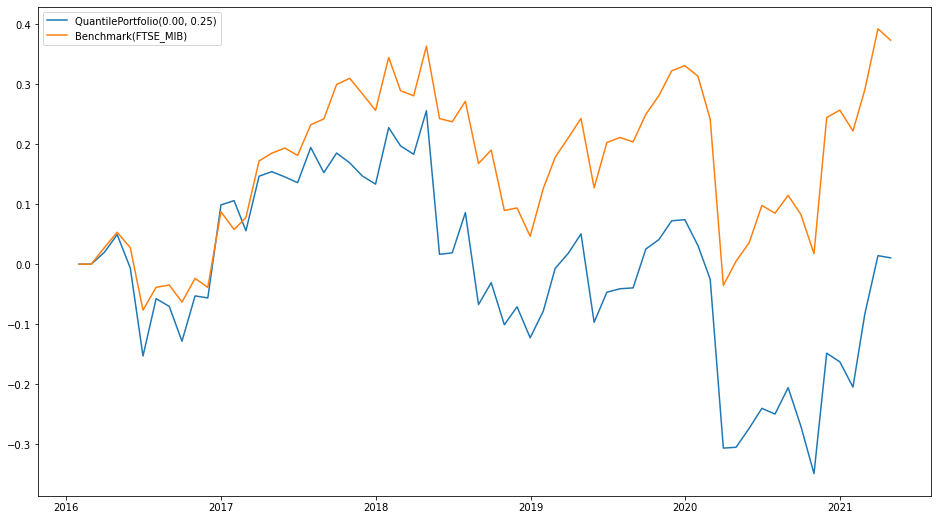

In [14]:
fm.portfolios[0].plot_cumulative_returns()
plt.legend()

## Сравниваем портфели 
tabulate пришлось убрать, поскольку при отрисовке больше 3 портфелей у меня слетало форматирование из-за того, что вывод не помещался. Пока временно сделал табличку с помощью пандаса

,"QuantilePortfolio(0.00, 0.25)","QuantilePortfolio(0.25, 0.50)","QuantilePortfolio(0.50, 0.75)","QuantilePortfolio(0.75, 1.00)"
"Alpha, %",-0.54,-0.26,-0.49,-0.18
Alpha p-value,0.15,0.53,0.20,0.75
Beta,1.33,0.85,0.75,0.74
Beta p-value,0.00,0.00,0.00,0.00
Sharpe Ratio,0.16,0.19,0.02,0.19
"Mean Return, %",0.39,0.32,0.04,0.33
"Excessive Return, %",-0.22,-0.29,-0.57,-0.27
"Total Return, %",1.05,9.05,-6.78,9.69
"Volatility, %",8.49,6.01,5.35,6.17
Benchmark Correlation,0.94,0.84,0.84,0.72


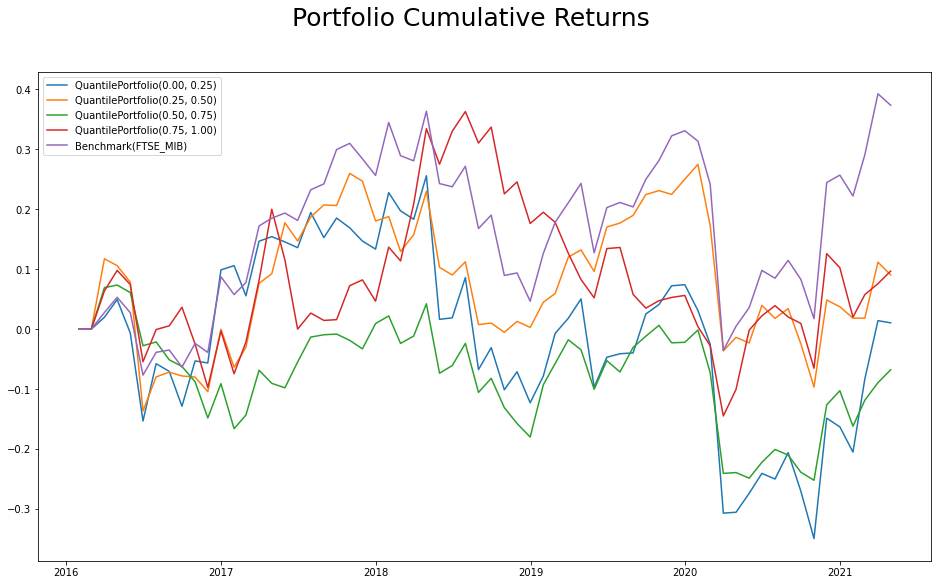

In [15]:
fm.compare_portfolios()

## Мультифакторы

In [16]:
# создаем (пока не реализован cs/ts)
intercept = InterceptMultiFactor([value, size])
nsort = NSortMultiFactor([value, size])
weighted = WeightedMultiFactor([value, size])

/home/akbabkin/notebooks/.datascience/lib/python3.8/site-packages/numpy/lib/nanfunctions.py:1389: RuntimeWarning: All-NaN slice encountered
  result = np.apply_along_axis(_nanquantile_1d, axis, a, q,


,"QuantilePortfolio(0.00, 0.33)","QuantilePortfolio(0.33, 0.67)","QuantilePortfolio(0.67, 1.00)"
"Alpha, %",-0.09,0.14,1.85
Alpha p-value,0.92,0.80,0.03
Beta,1.21,0.76,0.61
Beta p-value,0.00,0.00,0.00
Sharpe Ratio,0.26,0.37,1.05
"Mean Return, %",0.74,0.65,2.21
"Excessive Return, %",0.13,0.04,1.60
"Total Return, %",14.42,33.95,245.62
"Volatility, %",9.88,6.13,7.32
Benchmark Correlation,0.73,0.74,0.50


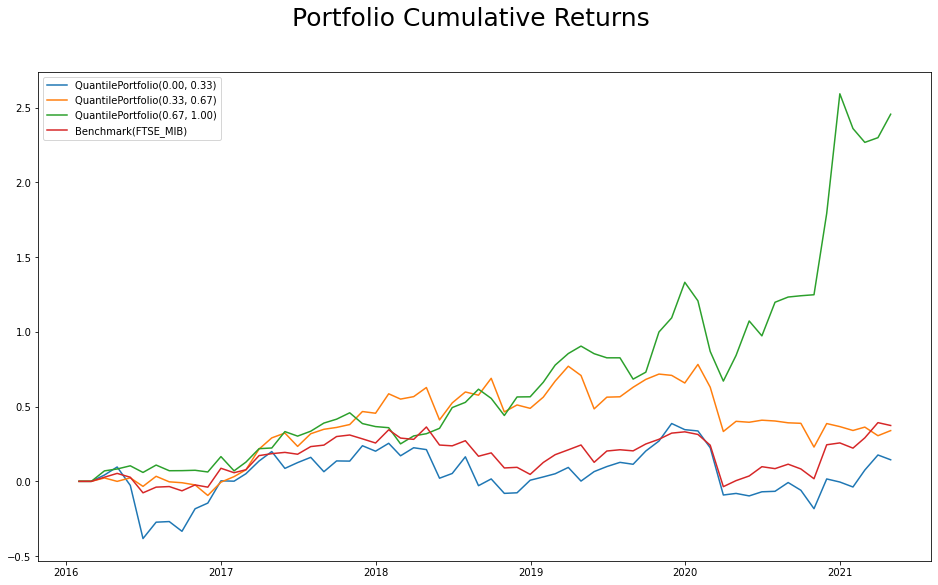

In [17]:
fm.fit(
    prices=prices,
    factor=intercept,
    filtering_factor=liquidity,
    weighting_factor=size_w,
    benchmark=benchmark,
    holding_period=20,
    n_quantile_portfolios=3 # вместо quantile_step указываем, сколько хотим портфелей
)
fm.compare_portfolios()

/home/akbabkin/notebooks/.datascience/lib/python3.8/site-packages/numpy/lib/nanfunctions.py:1389: RuntimeWarning: All-NaN slice encountered
  result = np.apply_along_axis(_nanquantile_1d, axis, a, q,
/home/akbabkin/PycharmProjects/pqr/pqr/factors/weightingfactor.py:12: RuntimeWarning: invalid value encountered in true_divide
  return weights / np.nansum(weights, axis=1)[:, np.newaxis]


,"QuantilePortfolio(0.00, 0.33)","QuantilePortfolio(0.33, 0.67)","QuantilePortfolio(0.67, 1.00)"
"Alpha, %",0.01,0.09,0.15
Alpha p-value,0.98,0.89,0.83
Beta,1.46,0.69,0.84
Beta p-value,0.00,0.00,0.00
Sharpe Ratio,0.34,0.30,0.33
"Mean Return, %",1.01,0.56,0.72
"Excessive Return, %",0.40,-0.05,0.11
"Total Return, %",33.93,24.74,32.36
"Volatility, %",10.28,6.40,7.43
Benchmark Correlation,0.85,0.64,0.68


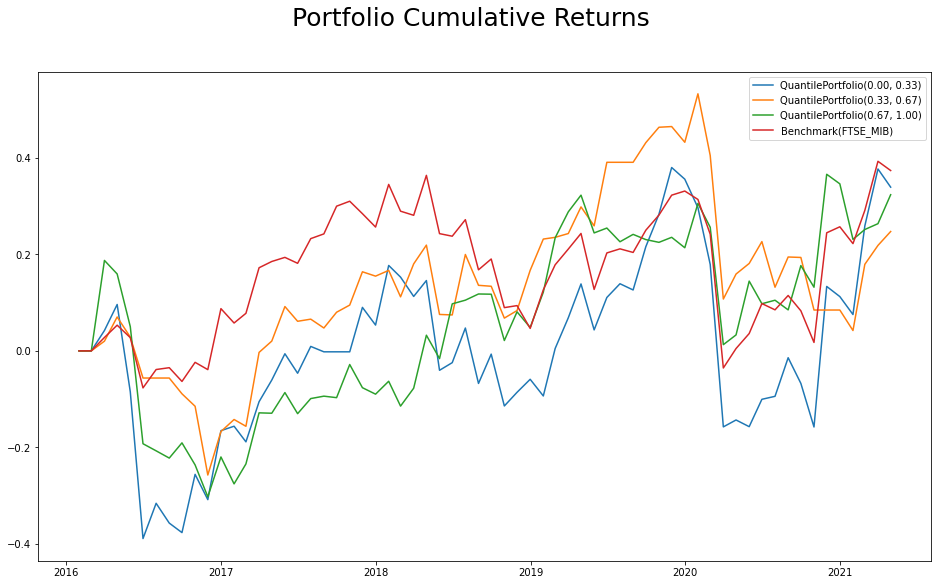

In [18]:
fm.fit(
    prices=prices,
    factor=nsort,
    filtering_factor=liquidity,
    weighting_factor=size_w,
    benchmark=benchmark,
    holding_period=2,
    n_quantile_portfolios=3
)
fm.compare_portfolios()

,"QuantilePortfolio(0.00, 0.33)","QuantilePortfolio(0.33, 0.67)","QuantilePortfolio(0.67, 1.00)"
"Alpha, %",-0.33,0.27,-0.53
Alpha p-value,0.63,0.44,0.01
Beta,1.35,0.96,1.05
Beta p-value,0.00,0.00,0.00
Sharpe Ratio,0.22,0.50,0.11
"Mean Return, %",0.60,0.91,0.20
"Excessive Return, %",-0.00,0.31,-0.40
"Total Return, %",8.45,57.59,-0.67
"Volatility, %",9.60,6.33,6.50
Benchmark Correlation,0.84,0.90,0.97


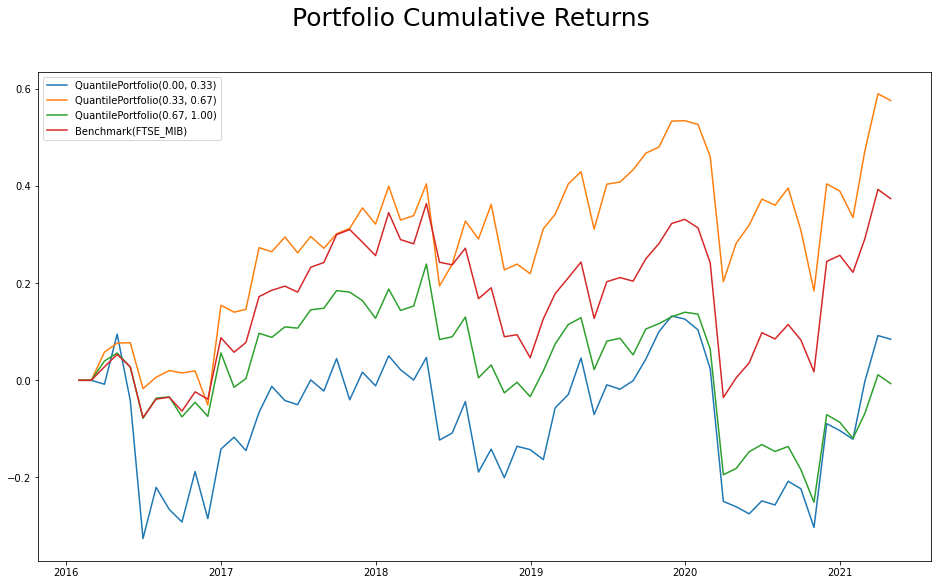

In [19]:
fm.fit(
    prices=prices,
    factor=weighted,
    filtering_factor=liquidity,
    weighting_factor=size_w,
    benchmark=benchmark,
    holding_period=2,
    n_quantile_portfolios=3
)
fm.compare_portfolios()